## About
* Person segmentation using DeepLab with Resnet101 backbone in PyTorch.

- Dataset Link - https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset

- About the Dataset
1. 2667 images of a segmented person from Supervise.ly


In [1]:
#importing libraries
import cv2
import os
import time
from os import listdir
from os.path import join, isdir
import numpy as np
from PIL import Image
import copy
import torch
from tqdm import tqdm
import glob
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
#!pip install torchsummary --quiet
#from torchsummary import summary
from collections import OrderedDict
from torchvision.datasets.vision import VisionDataset
from sklearn.metrics import f1_score, roc_auc_score



In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda")


True


In [3]:
!nvidia-smi

Tue Jan 31 23:16:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# os.chdir('/content/drive/MyDrive/Datasets/')
# !unzip person_seg.zip 

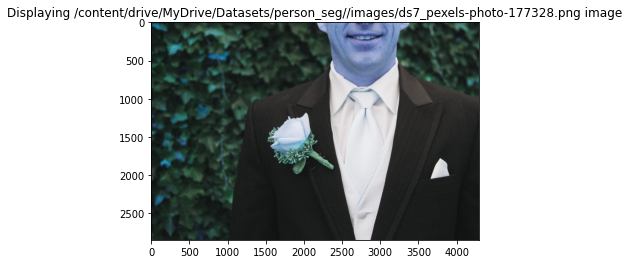

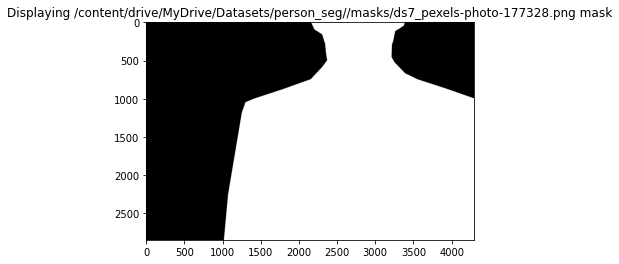

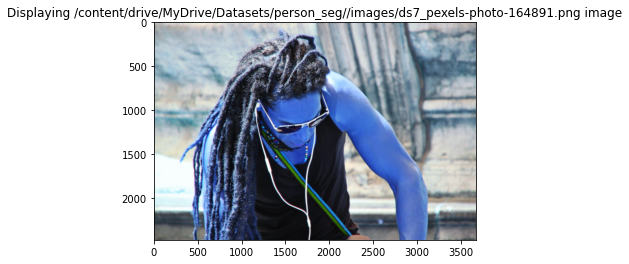

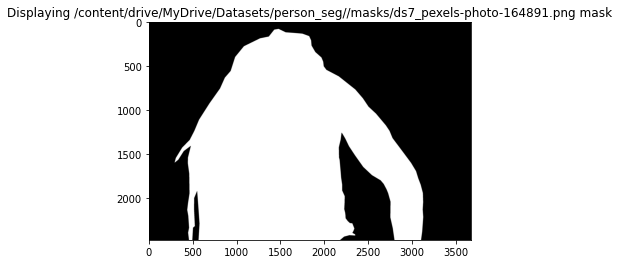

In [6]:
#visualising the data
dataset_path = "/content/drive/MyDrive/Datasets/person_seg/"
disp_count=0
for image_file in glob.glob(dataset_path+"/images/*.png"):
    mask_file_name = glob.glob(dataset_path+"/masks/"+image_file.split('/')[-1])[0]
    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file_name)
    plt.imshow(image)
    plt.title("Displaying {} image".format(image_file))
    plt.show()
    plt.imshow(mask)
    plt.title("Displaying {} mask".format(mask_file_name))
    plt.show()
    disp_count+=1
    if disp_count==2:
        break
    

In [7]:
# calculating mean and standard deviation for the training directory of images
num_channels = 3

def calculate_mean_std(dir):
    cls_dirs = [d for d in listdir(dir) if isdir(join(dir, d))]
    pixel_num = 0 
    channel_sum = np.zeros(num_channels)
    channel_sum_squared = np.zeros(num_channels)

    for idx, d in enumerate(cls_dirs):
        print("{} processing..".format(d))
        im_pths = glob.glob(join(dir, d, "*.png"))

        for path in im_pths:
            im = cv2.imread(path) 
            im = im/255.0
            pixel_num += (im.size/num_channels)
            channel_sum += np.sum(im, axis=(0, 1))
            channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # changing format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std

In [ ]:
mean,std = calculate_mean_std('/content/drive/MyDrive/Datasets/data')

In [ ]:
print(mean,std)

In [7]:
mean = [0.47652043075343925, 0.46125715723006117, 0.4438642526273379] #declaring to avoid re-computation
std = [0.3102351305207553, 0.3023731772681274, 0.30311972896556855]

In [7]:
# defining dataset class
#ensuring images,masks in root dir
class PersonDataset(VisionDataset):
    def __init__(self, root, image_folder, mask_folder, transforms=None,seed=None,
                fraction=None, subset=None, image_channel="rgb",mask_channel="grayscale"):

                super().__init__(root,transforms)
                self.image_folder = image_folder
                self.mask_folder = mask_folder
                image_path = self.root+"/"+self.image_folder
                mask_path = self.root+"/"+self.mask_folder

                self.image_channel = image_channel
                self.mask_channel = mask_channel

                if not fraction:
                    self.images = sorted(glob.glob(image_path+"/*"))
                    self.masks = sorted(glob.glob(mask_path+"/*"))
                else:
                    self.fraction = fraction 
                    self.images_list = np.array(sorted(glob.glob(image_path+"/*")))
                    self.masks_list = np.array(sorted(glob.glob(mask_path+"/*")))
                    if seed:
                        np.random.seed(seed)
                        #seeding to ensure constant val-train split
                        idxs = np.arange(len(self.images_list))
                        np.random.shuffle(idxs)
                        self.images_list = self.images_list[idxs]
                        self.masks_list = self.masks_list[idxs]
                    if subset == "Train":
                        self.images = self.images_list[:int(np.ceil(len(self.images_list) * (1 - self.fraction)))]

                        self.masks = self.masks_list[:int(np.ceil(len(self.masks_list) * (1 - self.fraction)))]
                    elif subset == "Val":
                        self.images = self.images_list[int(np.ceil(len(self.images_list) * (1 - self.fraction))):]
                        
                        self.masks = self.masks_list[int(np.ceil(len(self.masks_list) * (1 - self.fraction))):]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        mask_path = self.masks[index]

        #reading and applying transforms
        with open(image_path,"rb") as image_file, open(mask_path,"rb") as mask_file:
            image = Image.open(image_file)
            if self.image_channel =="rgb":
                image = image.convert("RGB")
            elif self.image_channel =="grayscale":
                image = image.convert("L")
            
            mask = Image.open(mask_file)
            if self.mask_channel=="rgb":
                mask = mask.convert("RGB")
            
            elif self.mask_channel=="grayscale":
                mask= mask.convert("L")
            
            data_dict = {"image":image, "mask":mask}

            if self.transforms:
                data_dict["image"] = self.transforms(data_dict["image"])
                data_dict["mask"] = self.transforms(data_dict["mask"])
            return data_dict
        


In [8]:
def create_dataloaders(root_dir, image_path, mask_path, fraction=0.2, batch_size=16):
    transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224, 224))])
    
    dataset_dict = {
        x:PersonDataset(root_dir,image_path,mask_path,seed=42,
        fraction=fraction, subset=x, transforms=transform)
        for x in ['Train','Val']
    }

    dataloader = {
        x:DataLoader(dataset_dict[x],batch_size=batch_size,shuffle=True, num_workers=1)
        for x in ['Train','Val']
    }

    return dataloader


In [9]:
dataloader = create_dataloaders(root_dir=dataset_path,image_path='images',mask_path='masks')

In [10]:
for batch in dataloader['Train']:
    print(batch['image'].dtype,batch['mask'].dtype)
    print(batch['image'].shape,batch['mask'].shape)
    break

torch.float32 torch.float32
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


## Tweaking DeepLab Model architecture for fine-tuning

In [11]:
def custom_deeplab_model(output_channel=1):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.classifier = DeepLabHead(2048,output_channel)
    
    return model

In [12]:
model = custom_deeplab_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
def fit(model,criterion,dataloader,optimizer,metrics,num_epochs):
    start_time = time.time()
    best_model_weight = copy.deepcopy(model.state_dict())
    best_loss=0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # log = {}
    # log['train_f1_score'] = []
    # log['train_other_metrics']=[]
    # log['val_f1_score'] = []
    # log['val_other_metrics']=[]
    # log['train_epoch_loss']=[]
    

    for epoch in range(num_epochs):
        for phase in ['Train','Val']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            for batch in tqdm(iter(dataloader[phase])):
                images = batch['image'].to(device)
                mask = batch['mask'].to(device)
                #print(images.dtype,mask.dtype)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='Train'):
                    
                    output_mask = model(images)
                    
                    loss = criterion(output_mask['out'],mask)

                    y_pred = output_mask['out'].data.cpu().numpy().ravel()
                    y_true = mask.data.cpu().numpy().ravel()

                    #calculating metrics
                    for name,metric in metrics.items():
                        if name =="f1_score":
                            f1_score = metric(y_true > 0, y_pred > 0.1)

                        else:
                            roc_auc = metric(y_true.astype('uint8'), y_pred)

                    if phase =="Train":
                        loss.backward()
                        optimizer.step()
                    
            epoch_loss = loss
            
            print("Epoch- {}/{} :: Loss - {}, f1-score- {}, ROC_AUC-{}".format(epoch,num_epochs,epoch_loss.item(),f1_score,roc_auc))

            if phase=="Val" and loss.item()<best_loss:
                best_loss = loss.item()
                best_model_weight = copy.deepcopy(model.state_dict())

        end_time = time.time() - start_time

        print("Training done in {} with least loss:{}".format(end_time-start_time,best_loss))

        #saving model
        model.load_state_dict(best_model_weight)
        torch.save(model.state_dict(),"/content/drive/MyDrive/Datasets/person_seg_224_224.pt")
    return model


In [27]:
# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

model = fit(model,criterion,dataloader,optimizer,metrics,20)

100%|██████████| 134/134 [04:50<00:00,  2.17s/it]

Epoch- 0/20 :: Loss - 0.05247610807418823, f1-score- 0.8563452626877337, ROC_AUC-0.9867335220263843



100%|██████████| 34/34 [01:00<00:00,  1.77s/it]


Epoch- 0/20 :: Loss - 0.02037220448255539, f1-score- 0.8798680045552776, ROC_AUC-0.9929293402758363
Training done in -1675207721.4838479 with least loss:0.0


100%|██████████| 134/134 [04:52<00:00,  2.18s/it]

Epoch- 1/20 :: Loss - 0.019197823479771614, f1-score- 0.8570224888157763, ROC_AUC-0.9929969926594486



100%|██████████| 34/34 [01:00<00:00,  1.78s/it]


Epoch- 1/20 :: Loss - 0.02922418899834156, f1-score- 0.894888456276965, ROC_AUC-0.9837838939239557
Training done in -1675207367.3431196 with least loss:0.0


100%|██████████| 134/134 [04:51<00:00,  2.17s/it]

Epoch- 2/20 :: Loss - 0.04818534106016159, f1-score- 0.9038497466838108, ROC_AUC-0.9740043725203364



100%|██████████| 34/34 [01:02<00:00,  1.85s/it]


Epoch- 2/20 :: Loss - 0.027138667181134224, f1-score- 0.9363888652099376, ROC_AUC-0.9850814974527675
Training done in -1675207012.4007564 with least loss:0.0


100%|██████████| 134/134 [04:51<00:00,  2.17s/it]

Epoch- 3/20 :: Loss - 0.02687208727002144, f1-score- 0.8602584134053123, ROC_AUC-0.9888093165796461



100%|██████████| 34/34 [01:00<00:00,  1.77s/it]


Epoch- 3/20 :: Loss - 0.05244237929582596, f1-score- 0.8566763734723966, ROC_AUC-0.9546372572327512
Training done in -1675206660.0636847 with least loss:0.0


100%|██████████| 134/134 [04:48<00:00,  2.15s/it]

Epoch- 4/20 :: Loss - 0.03451108559966087, f1-score- 0.7931038384935722, ROC_AUC-0.9863771474572121



100%|██████████| 34/34 [00:58<00:00,  1.73s/it]


Epoch- 4/20 :: Loss - 0.022707568481564522, f1-score- 0.9566912010705922, ROC_AUC-0.9806612046075249
Training done in -1675206311.2640843 with least loss:0.0


100%|██████████| 134/134 [04:50<00:00,  2.17s/it]

Epoch- 5/20 :: Loss - 0.03897881135344505, f1-score- 0.7512989070571017, ROC_AUC-0.9872267549466929



100%|██████████| 34/34 [01:00<00:00,  1.78s/it]


Epoch- 5/20 :: Loss - 0.11127051711082458, f1-score- 0.8171834659710947, ROC_AUC-0.9252827808211466
Training done in -1675205959.0676591 with least loss:0.0


100%|██████████| 134/134 [04:49<00:00,  2.16s/it]

Epoch- 6/20 :: Loss - 0.02525998465716839, f1-score- 0.8606468690225476, ROC_AUC-0.9880821194400996



100%|██████████| 34/34 [01:00<00:00,  1.79s/it]


Epoch- 6/20 :: Loss - 0.032390348613262177, f1-score- 0.8958026735344616, ROC_AUC-0.9864314947012434
Training done in -1675205607.683046 with least loss:0.0


 89%|████████▉ | 119/134 [04:20<00:31,  2.12s/it]

## Inference

In [23]:
# test sample 1
#reading
img = cv2.imread('/content/test1.jpg')
# resizing
img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
img = img.transpose(2,0,1).reshape(1,3,224,224)
with torch.no_grad():
  out = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)


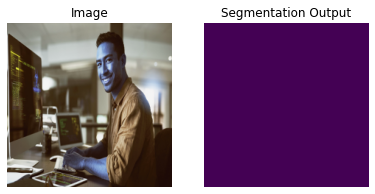

In [25]:
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(out['out'].cpu().detach().numpy()[0][0]>0.5);
plt.title('Segmentation Output')
plt.axis('off');
plt.savefig('Out.png',bbox_inches='tight')